In [4]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import astropy.io.fits as fits

def VrpmUVW(ra, dec, Vr, pmra, pmdec, D, Vrerr, pmraerr, pmdecerr, Derr, velsun):
    '''
    Vpm2UVW converts radial velocities and proper motions to 3D velocities.
    Parameters:
    Vr: radial velocity from observation
    pmra, pmdec: proper motion in equatorial coordinates
    ra,dec:equatorial coordinates
    D: distance to the Sun in pc.
    Return:
    U, V, W: 3D velocity components with respect to LSR
    REF:Johnson & Soderblom(1987)
    '''
    #velsun = [10,5.25,7.17]
    #velsun = [9.58,10.52,7.01]
#    velsun = [9.58,20,7.01]
#    T=[[-0.06699, -0.87276, -0.48354]
#       [+0.49273, -0.45035, +0.74458] 
#       [-0.86760, -0.18837, +0.46020]]
    k = 4.74057 
    ra0 = ra*np.pi/180.0
    dec0 = dec*np.pi/180.0
    cra = np.cos(ra0)
    sra = np.sin(ra0)
    cdec = np.cos(dec0)
    sdec = np.sin(dec0)
    
    
    B11=-0.063491*cra*cdec -0.86554 *sra*cdec -0.496799*sdec
    B12= 0.063491*sra       -0.86554 *cra       +0
    B13= 0.063491*cra*sdec +0.86554 *sra*sdec -0.496799*cdec
    
    B21= 0.493076*cra*cdec -0.460007*sra*cdec +0.738424*sdec
    B22=-0.493076*sra       -0.460007*cra       +0
    B23=-0.493076*cra*sdec +0.460007*sra*sdec +0.738424*cdec
    
    B31=-0.867666*cra*cdec -0.198076*sra*cdec +0.455984*sdec
    B32= 0.867666*sra       -0.198076*cra       +0
    B33= 0.867666*cra*sdec +0.198076*sra*sdec +0.455984*cdec
    
    U = velsun[0]+Vr*B11+k*pmra*D*B12/1000.0+k*pmdec*D*B13/1000.0
    V = velsun[1]+Vr*B21+k*pmra*D*B22/1000.0+k*pmdec*D*B23/1000.0
    W = velsun[2]+Vr*B31+k*pmra*D*B32/1000.0+k*pmdec*D*B33/1000.0
    Uerr = np.sqrt(B11**2*Vrerr**2+\
        (k*B12/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B13/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
    Verr=np.sqrt(B21**2*Vrerr**2+\
        (k*B22/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B23/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
    Werr=np.sqrt(B31**2*Vrerr**2+\
        (k*B32/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B33/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
        
    return U,V,W,Uerr,Verr,Werr



def velocitycart2cylindrical(U,V,W,l,b,dist,Uerr,Verr,Werr,disterr,Vlsr,Rsun):
    '''
        Convert the UVW to velocity compoennts in cylindrical coordinates
        Parameters:
        U: velocity in X, in km/s
        V: velocity in Y, in km/s
        W: velocity in Y, in km/s
        l,b: Galactic coordniates, in degrees
        dist: distance in pc
        Vlsr circular speed at LSR
        Rsun: distance from the Galactic center to the Sun;\
    '''

    cbsl=np.cos(deg2rad(b))*np.sin(deg2rad(l))
    cbcl=np.cos(deg2rad(b))*np.cos(deg2rad(l))
    tanphi=(dist*cbsl/(Rsun-dist*cbcl))
    tanphierr2=disterr**2*(cbsl**2*Rsun**2)/(Rsun-dist*cbcl)**4
    phi=np.arctan(tanphi)
    phierr2=tanphierr2/(1+tanphi**2)**2
    VR=-np.cos(phi)*U+np.sin(phi)*(V+Vlsr)
    VPhi=np.sin(phi)*U+np.cos(phi)*(V+Vlsr)
    VZ=W
    VRerr=np.sqrt((np.cos(phi)**2)*(Uerr**2)+(np.sin(phi)**2)*(Verr**2)+\
                  ((U*np.sin(phi)+(V+Vlsr)*np.cos(phi))**2)*phierr2)
    VPhierr=np.sqrt((np.sin(phi)**2)*(Uerr**2)+(np.cos(phi)**2)*(Verr**2)+\
                  ((U*np.cos(phi)-(V+Vlsr)*np.sin(phi))**2)*phierr2)
    VZerr=Werr
    phi0=phi
    return VR,VPhi,VZ,VRerr,VPhierr,VZerr,phi0
    
def velocity(tgas0, V0, velsun, Rsun):
    '''
        derive velocities with lamost-tgas catalog
        Parameters:
        tgas0: the lamost-tgas catalog
        V0: the circular speed at LSR
        velsun: the solar motion wrt. the LSR
        Rsun: the distance from the Galactic center to the Sun
    '''
    U, V, W, Uerr, Verr, Werr =\
        VrpmUVW(tgas0.ra_tgas,tgas0.dec_tgas,tgas0.rv+5.7,tgas0.pmra_tgas,tgas0.pmdec_tgas,\
        tgas0.dist_tgas,np.repeat(5.0,len(tgas0.obsid)),\
        tgas0.pmra_error_tgas,tgas0.pmdec_error_tgas,\
        tgas0.dist_tgas*tgas0.dist_error_tgas, velsun)
    VR,VPHI,VZ,VRerr,VPHIerr,VZerr, PHI0 = velocitycart2cylindrical(U,V,W,\
        tgas0.l_tgas,tgas0.b_tgas,\
        tgas0.dist_tgas,Uerr,Verr,Werr,tgas0.dist_tgas*tgas0.dist_error_tgas,\
        V0,Rsun)
    return U, V, W, Uerr, Verr, Werr,VR,VPHI,VRerr,VPHIerr


def loadData(filename):
    '''
    Read fits data
    '''
    tchfits = fits.open(filename)
    tgas = tchfits[1].data
    return tgas
	
 
def drawInplaneVelDist(VR,VPHI):
    '''
    draw distribution of VR vs. VPhi
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(VR,VPHI,'k.',markersize=2)
    ax.set_xlim([-150,150])
    ax.set_ylim([0,300])
    fig.show()
    
    
def drawHRdiagram(Teff,MK):
    '''
    draw Teff-MK (HR) diagram
    '''
    Tgrid = np.linspace(3500,9000,num=50)
    Mgrid = np.linspace(-10,10,num=100)
    HRD,xedges,yedges = np.histogram2d(MK,Teff,bins=[Mgrid,Tgrid])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.imshow(HRD,extent=[yedges[0],yedges[-1],xedges[-1],xedges[0]])
    ax.contour(HRD,20,extent=[yedges[0],yedges[-1],xedges[0],xedges[-1]])    
    ax.set_aspect('auto')
    ax.set_xlim([8500,3600])
    ax.set_ylim([10,-10])
    plt.xlabel(r'$T_{\rm eff}$')
    plt.ylabel(r'$M_K$')
    fig.show()
    

/Users/chaoliu/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


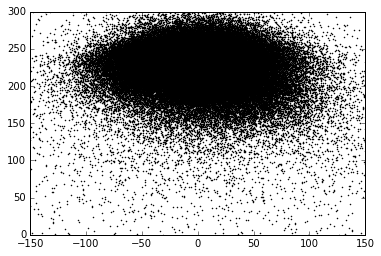

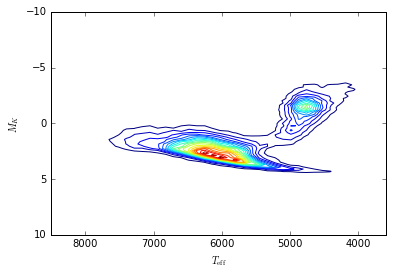

In [5]:
filename = '/Users/chaoliu/pyw/TGAS/LAMOST_DR3_TGAS.fits'
tgas = loadData(filename)
V0 = 238 #km/s
velsun1 = [9.58,10.52,7.01] #Tian et al. 2015
Rsun = 8340 #Reid 2014 in parsec
U, V, W, Uerr, Verr, Werr,VR,VPHI,VRerr,VPHIerr = velocity(tgas,V0,velsun1,Rsun)
drawInplaneVelDist(VR,VPHI)
drawHRdiagram(tgas.teff,tgas.MK_tgas)